## Tải dữ liệu

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'face-mask-12k-images-dataset' dataset.
Path to dataset files: /kaggle/input/face-mask-12k-images-dataset


## Thư viện

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


## Xử lý dữ liệu

In [ ]:
dataset_path = os.path.join(path, "Face Mask Dataset")
train_dir = os.path.join(dataset_path, "Train")
val_dir = os.path.join(dataset_path, "Validation")
test_dir = os.path.join(dataset_path, "Test")

In [ ]:
image_size = (224, 224)
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_size,
                                               batch_size=batch_size,
                                               class_mode='categorical')

val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           class_mode='categorical')

test_data = val_datagen.flow_from_directory(test_dir,
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                            shuffle=False)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


## Train Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
INIT_LR = 1e-4
EPOCHS = 10

baseModel = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

# --- Stage 1: Train head ---
for layer in baseModel.layers:
    layer.trainable = False

opt = Adam(learning_rate=1e-4)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

print("=== Stage 1: Training classifier head ===")
H1 = model.fit(train_data, validation_data=val_data, epochs=5, callbacks=[early_stop])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
=== Stage 1: Training classifier head ===
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 179s 523ms/step - accuracy: 0.8417 - loss: 0.3993 - val_accuracy: 0.9800 - val_loss: 0.0840
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 147s 470ms/step - accuracy: 0.9624 - loss: 0.1177 - val_accuracy: 0.9875 - val_loss: 0.0502
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 466ms/step - accuracy: 0.9734 - loss: 0.0851 - val_accuracy: 0.9887 - val_loss: 0.0399
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 465ms/step - accuracy: 0.9765 - loss: 0.0747 - val_accuracy: 0.9900 - val_loss: 0.0328
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 147s 469ms/step - accuracy: 0.9825 - loss: 0.0592 - val_accuracy: 0.9887 - val_loss: 0.0316


In [ ]:
# --- Stage 2: Fine-tuning ---
for layer in baseModel.layers[-50:]:  # mở khóa 50 layer cuối cùng
    layer.trainable = True

opt_finetune = Adam(learning_rate=1e-5)
model.compile(loss="binary_crossentropy", optimizer=opt_finetune, metrics=["accuracy"])

print("=== Stage 2: Fine-tuning backbone ===")
H2 = model.fit(train_data, validation_data=val_data, epochs=15, callbacks=[early_stop])

=== Stage 2: Fine-tuning backbone ===
Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 186s 524ms/step - accuracy: 0.8983 - loss: 0.2677 - val_accuracy: 0.9725 - val_loss: 0.0646
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 177s 479ms/step - accuracy: 0.9814 - loss: 0.0634 - val_accuracy: 0.9837 - val_loss: 0.0391
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 151s 481ms/step - accuracy: 0.9829 - loss: 0.0456 - val_accuracy: 0.9900 - val_loss: 0.0200
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 466ms/step - accuracy: 0.9870 - loss: 0.0343 - val_accuracy: 0.9925 - val_loss: 0.0142
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 202s 468ms/step - accuracy: 0.9909 - loss: 0.0312 - val_accuracy: 0.9975 - val_loss: 0.0091
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 201s 467ms/step - accuracy: 0.9917 - loss: 0.0251 - val_accuracy: 0.9987 - val_loss: 0.0107
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 475ms/step - accuracy: 0.9925 - loss: 0.0225 - val_accuracy: 0.9975 - val_loss: 0.0102
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━

## Training Curve

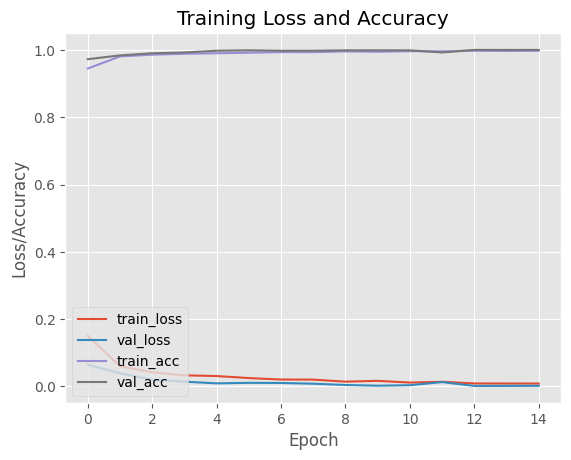

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
N = len(H2.history["loss"])

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H2.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H2.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H2.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H2.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## Đánh giá trên tập test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# Dự đoán trên test set
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

class_labels = list(test_data.class_indices.keys())

# In classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step
              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00       483
 WithoutMask       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



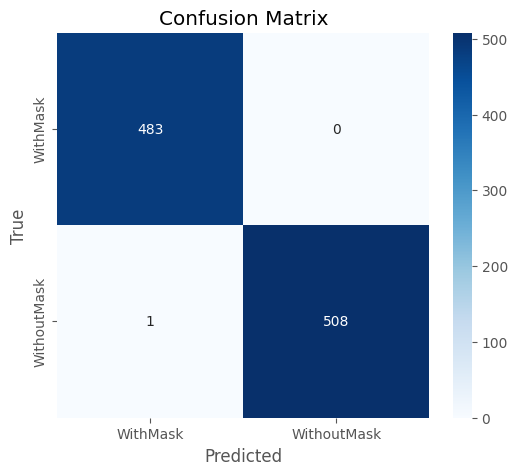

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
loss, acc = model.evaluate(test_data)
print(f"Độ chính xác trên tập test: {acc*100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9993 - loss: 0.0057
Độ chính xác trên tập test: 99.90%


## Lưu model

In [ ]:
model.save('model.keras')

In [ ]:
from google.colab import files

# Tải về máy
files.download("model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>